In [1]:
import aopy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats("retina")
plt.rcParams['font.family'] = 'Arial'

# EVENT CODE
CENTER_TARGET_ON = 16
CURSOR_ENTER_CENTER_TARGET = 80
CURSOR_ENTER_PERIPHERAL_TARGET = list(range(81,89))
PERIPHERAL_TARGET_ON = list(range(17,25))
CENTER_TARGET_OFF = 32
REWARD = 48
DELAY_PENALTY = 66
TIMEOUT_PENALTY = 65
HOLD_PENALTY = 64
PAUSE = 254
TIME_ZERO = 238
TRIAL_END = 239
END_TRIAL_CODE = TRIAL_END

/home/aolab/miniconda3/envs/tomo-analysis/lib/python3.9/site-packages/one/alf/files.py:10: FutureWarning: `one.alf.files` will be removed in version 3.0. Use `one.alf.path` instead.
  warnings.warn(


# Load data

In [2]:

preproc_dir = '/data/preprocessed'
date = '2022-06-28'
subject = 'beignet'
te_id = 5927
trial_filter = lambda t: REWARD in t

# Load experiment data
data, metadata = aopy.data.load_preproc_exp_data(preproc_dir, subject, te_id, date)

# Load cursor data
cursor_traj, tsegs = aopy.data.get_kinematic_segments(preproc_dir, subject, te_id, date, \
    CURSOR_ENTER_CENTER_TARGET, TRIAL_END, trial_filter=trial_filter)

# Load eye data
eye_data, eye_metadata = aopy.data.load_preproc_eye_data(preproc_dir, subject, te_id, date)
eye_traj, _ = aopy.data.get_kinematic_segments(preproc_dir, subject, te_id, date, \
    CURSOR_ENTER_CENTER_TARGET, TRIAL_END, trial_filter=trial_filter, datatype='eye')    

# Load target positions
target_pos = aopy.data.get_target_locations(preproc_dir, subject, te_id, date, [0,1,2,3,4,5,6,7,8])

# Get event times    
segs, times = aopy.preproc.base.get_trial_segments_and_times(data['events']['code'], data['events']['timestamp'],\
    CURSOR_ENTER_CENTER_TARGET, TRIAL_END)
times = [t for s, t in zip(segs, times) if trial_filter(s)]

# Get target index for each trial
target_idx = np.array([int(seg[1] - CENTER_TARGET_ON ) for seg in tsegs])

fs_cursor = metadata['cursor_interp_samplerate']
fs_eye = eye_metadata['samplerate']

# Movement onset

In [3]:
# Collect event times
print(segs[0])
print(times[0])

trial_start = np.array([t[0] for t in times])
target_onset = np.array([t[1] for t in times])
gocue = np.array([t[2] for t in times])

# Compute movement onset
movement_onset = aopy.analysis.get_movement_onset(cursor_traj, fs_cursor, \
    trial_start, target_onset, gocue, numsd=3.0, butter_order=4, low_cut=20, thr=5)

[ 80  20  32  84  48 239]
[19.91988 20.12824 20.26132 20.69504 20.91988 21.0288 ]


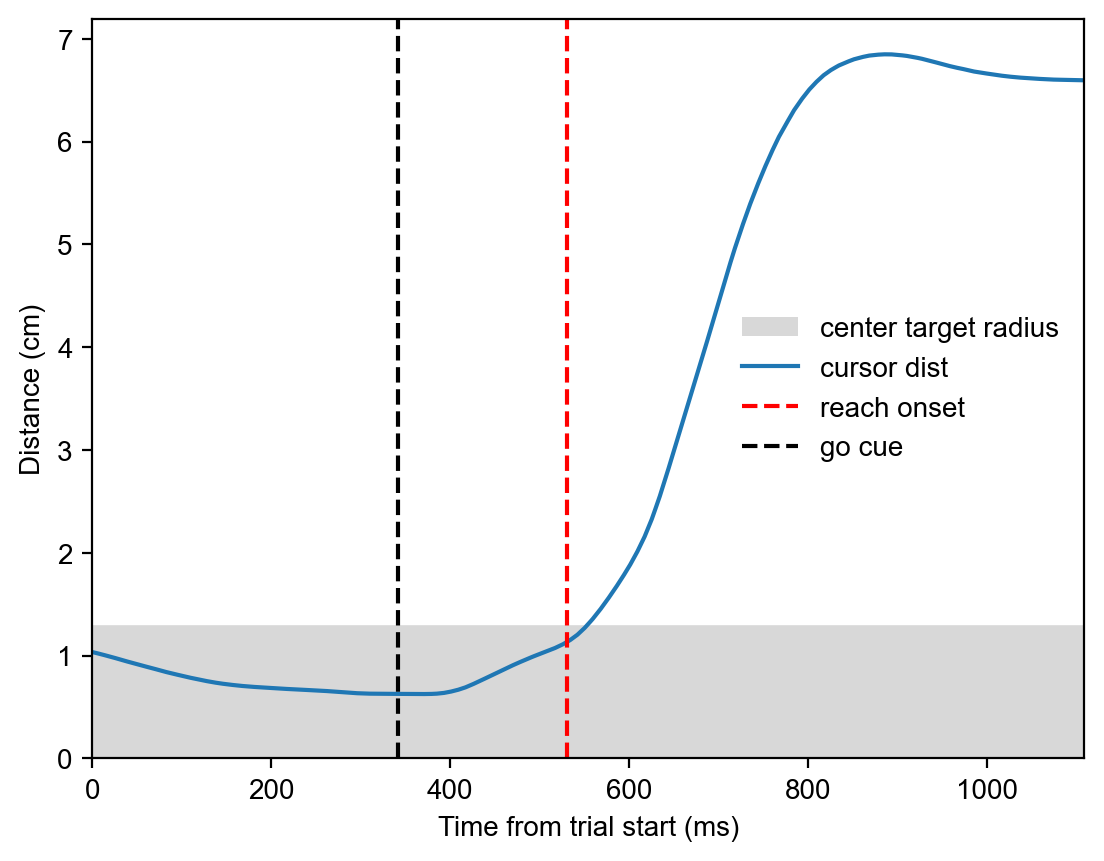

In [127]:
# Show example
itr = 0
dist = np.linalg.norm(cursor_traj[itr], axis=1)
t_axis = np.arange(dist.shape[0])/fs_cursor*1000
target_radius = metadata['target_radius']

fig,ax=plt.subplots()
ax.fill_between(t_axis, 0, target_radius, color='gray', linewidth=0, alpha=0.3, label='center target radius')
ax.plot(t_axis, dist, label='cursor dist')
ax.axvline(movement_onset[itr]*1000, color='r', linestyle='--', label='reach onset')
ax.axvline((gocue[itr]-trial_start[itr])*1000, color='k', linestyle='--', label='go cue')
ax.set(xlim=(t_axis[0],t_axis[-1]), ylim=(0,None), xlabel='Time from trial start (ms)', ylabel='Distance (cm)')
ax.legend(frameon=False)

# Saccade onset

In [128]:
fs_down = fs_eye
sac_radius = 2.

onset = []
duration = []
distance = []
onset_pos = []
offset_pos = []
onset_target = []
offset_target = []
onset_event = []
offset_event = []
saccade_idx = []
onset_target = []

for itr in range(eye_traj.shape[0]):
    ave_eye_traj = np.stack([(eye_traj[itr][:,0]+eye_traj[itr][:,2])/2, (eye_traj[itr][:,1]+eye_traj[itr][:,3])/2]).T
    
    # Get saccade onset, duration, and ditance
    onset_tmp, duration_tmp, distance_tmp = aopy.precondition.detect_saccades(ave_eye_traj, fs_eye, num_sd=1.5, lowpass_filter_freq=30)
    
    # Get saccade start position and saccade end position
    onset_pos_tmp, offset_pos_tmp = aopy.postproc.get_saccade_pos(ave_eye_traj, np.array(onset_tmp), np.array(duration_tmp), fs_down)
    
    # Get target index a subject looked at during a saccade
    onset_target_tmp, offset_target_tmp = aopy.postproc.get_saccade_target_index(onset_pos_tmp, offset_pos_tmp, target_pos[:,:2], sac_radius)
    
    # Get relevant task event when a saccade happens
    event_times_from_trial_start = times[itr]-times[itr][0]
    onset_event_tmp, offset_event_tmp = aopy.postproc.get_saccade_event(np.array(onset_tmp), np.array(duration_tmp), event_times_from_trial_start , tsegs[itr])
    
    # Get relevant saccade
    saccade_idx_tmp = aopy.postproc.get_relevant_saccade_idx(onset_target_tmp, offset_target_tmp, distance_tmp, target_idx[itr])
    
    onset.append(onset_tmp)
    duration.append(duration_tmp)
    distance.append(distance_tmp)
    onset_pos.append(onset_pos_tmp)
    offset_pos.append(offset_pos_tmp)
    onset_target.append(onset_target_tmp)
    offset_target.append(offset_target_tmp)
    onset_event.append(onset_event_tmp)
    offset_event.append(offset_event_tmp)
    saccade_idx.append(saccade_idx_tmp)

In [134]:
itr = 0

print(f'Target index for this trial: {target_idx[itr]}')
print(f'saccade timings from trial start: {onset[itr]*1000} ms')
print(f'Target a subject looked at before saccades: {onset_target[itr]}')
print(f'Target a subject looked at after saccades: {offset_target[itr]}')
print(f'relevant saccade index: {saccade_idx[itr]}')

Target index for this trial: 4
saccade timings from trial start: [ 65. 533. 635. 924. 949.] ms
Target a subject looked at before saccades: [0 0 0 4 4]
Target a subject looked at after saccades: [0 0 4 4 4]
relevant saccade index: 2


[Text(0.5, 0, 'Time from trial start (ms)'),
 Text(0, 0.5, 'Position (cm)'),
 (0.0, 1108.0)]

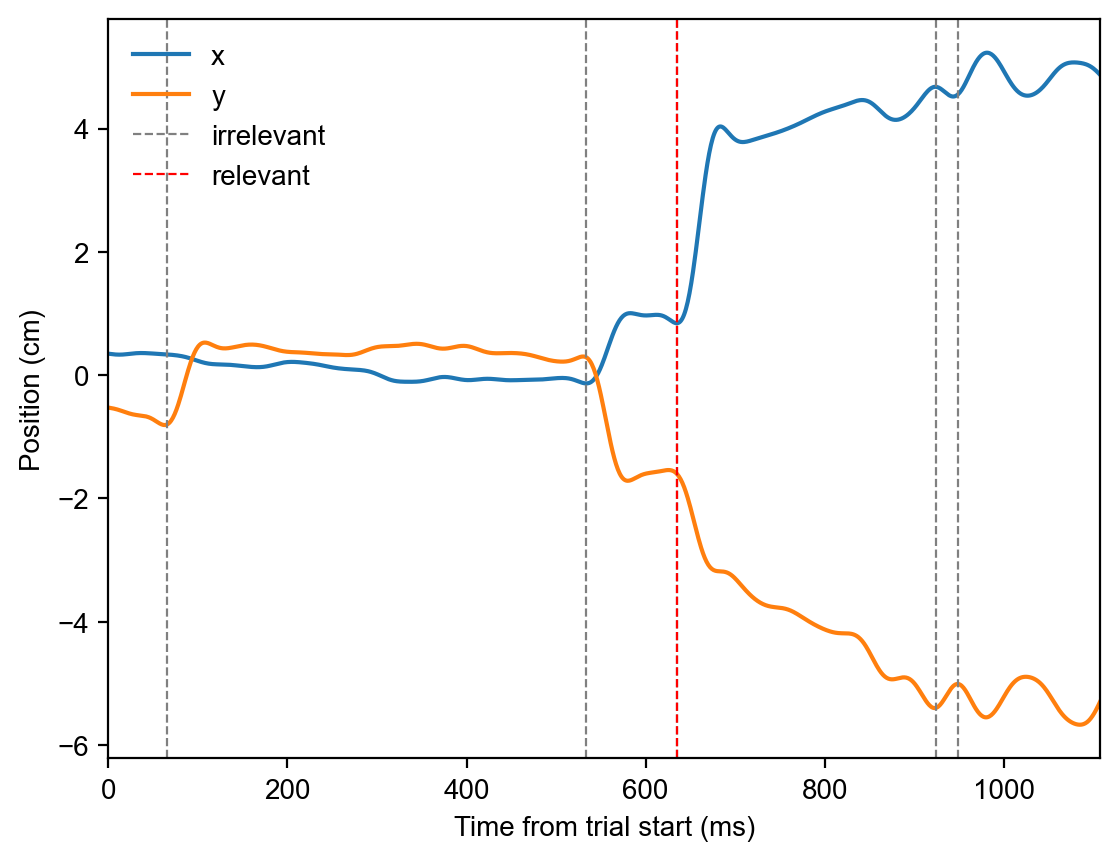

In [133]:
fig, ax = plt.subplots()
ave_eye_traj = np.stack([(eye_traj[itr][:,0]+eye_traj[itr][:,2])/2, (eye_traj[itr][:,1]+eye_traj[itr][:,3])/2]).T
t_axis = np.arange(ave_eye_traj.shape[0])/fs_eye*1000

h1, = ax.plot(t_axis, ave_eye_traj[:,0])
h2, = ax.plot(t_axis, ave_eye_traj[:,1])

# Show timings of all saccades
for sac in onset[itr]:
    h3 = ax.axvline(sac*1000, color='gray',linestyle='--', linewidth=0.8)
    
# Show the relevant saccade timing
h4 = ax.axvline(onset[itr][saccade_idx[itr]]*1000, color='r',linestyle='--', linewidth=0.8)


ax.legend(handles=[h1,h2,h3,h4],labels=['x','y','irrelevant','relevant'], frameon=False)
ax.set(xlabel='Time from trial start (ms)', ylabel='Position (cm)', xlim=(t_axis[0],t_axis[-1]))